In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Load data from CSV
file_path = 'final_manglish.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['commentText'] = data['commentText'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding
max_words = 1000
max_seq_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['commentText'])

sequences = tokenizer.texts_to_sequences(data['commentText'])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# Prepare target variable
labels = np.asarray(data['Sentiment_Class'])

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and sequence padding for balanced data
sequences_upsampled = tokenizer.texts_to_sequences(data_upsampled['commentText'])
padded_sequences_upsampled = pad_sequences(sequences_upsampled, maxlen=max_seq_length, padding='post', truncating='post')

# Prepare target variable for upsampled data
labels_upsampled = np.asarray(data_upsampled['Sentiment_Class'])

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_upsampled, labels_upsampled, test_size=0.2, random_state=10)

# Build Bi-LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=16))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model with early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=callbacks)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numerical labels back to original sentiment labels
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels = [reverse_sentiment_dict[label] for label in y_pred_classes]

# Print complete classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=sentiment_dict.keys()))


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.3262 - loss: 1.4944 - val_accuracy: 0.5471 - val_loss: 1.1514
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5895 - loss: 1.0502 - val_accuracy: 0.6344 - val_loss: 0.9699
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6782 - loss: 0.8696 - val_accuracy: 0.6738 - val_loss: 0.8934
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7141 - loss: 0.7891 - val_accuracy: 0.6897 - val_loss: 0.8416
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7369 - loss: 0.7365 - val_accuracy: 0.6996 - val_loss: 0.8414
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7549 - loss: 0.6931 - val_accuracy: 0.7225 - val_loss: 0.7809
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7647 - loss: 0.6761 - val_accuracy: 0.7358 - val_loss: 0.7576
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7768 - loss: 0.6420 - v

In [3]:
data_upsampled.value_counts()


product_category  product_name         link                                              commentDate          commentText                                                                                                                                                                                                                                                                          Sentiment_Class
Smartwatch        Amazfit GTR 3 Pro    https://www.youtube.com/watch?v=CHP8B0tArEM       2021-12-11 23:41:45  രണ്ട് വർഷമായി Amazfit GTR ഉപയോഗിക്കുന്നു. Excellent battery life. Calling facility, SPO2 എന്നിവ ഇല്ല എന്നുള്ളത് ഒരു drawback ആണ്. But still I like it.                                                                                                                               3                  21
Mobile            iphone 13            https://www.youtube.com/watch?v=8maloCt2-0g&t=3s  2021-11-06 15:27:03  applnte ഒരു ബിസിനസ് ഭാഗം ആയിട്ടാണ് 12/13 ഒക്കെ ഇറക്കുന്നത് പുതിയ device വാങ്ങു

In [5]:
class_counts = data_upsampled['Sentiment_Class'].value_counts()
for sentiment_class, count in class_counts.items():
    print(f"Class: {sentiment_class}, Count: {count}")


Class: 0, Count: 6287
Class: 1, Count: 6287
Class: 2, Count: 6287
Class: 3, Count: 6287
Class: 4, Count: 6287


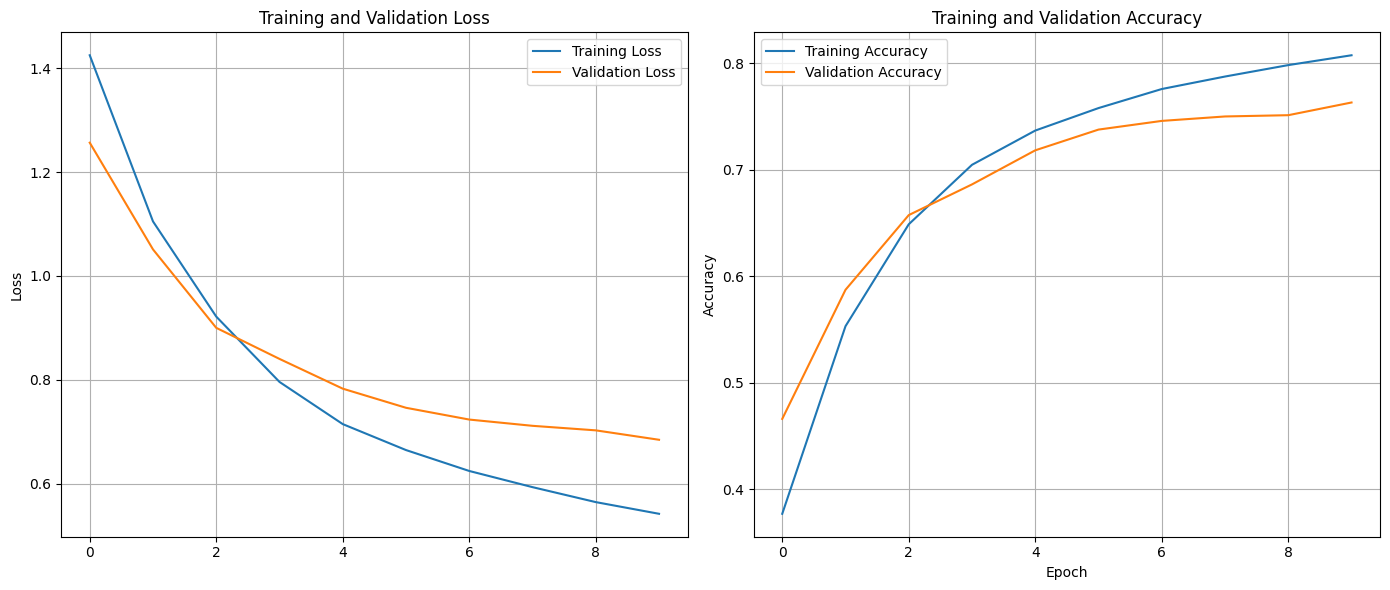

In [30]:
import matplotlib.pyplot as plt

# Create a figure and axes for horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot Training and Validation Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Training and Validation Accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
